In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file = os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
print(file)

/kaggle/input/heart-failure-prediction/heart.csv


In [3]:
df = pd.read_csv(file)
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
# convert categorical features with n outputs into n binary features
one_hot_encoding = ['Sex',
'ChestPainType',
'RestingECG',
'ExerciseAngina',
'ST_Slope'
]
df = pd.get_dummies(data = df, prefix = one_hot_encoding, columns = one_hot_encoding)

In [5]:
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,False,True,False,...,False,False,False,True,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,True,False,False,...,True,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,False,True,False,...,False,False,False,False,True,True,False,False,False,True
3,48,138,214,0,108,1.5,1,True,False,True,...,False,False,False,True,False,False,True,False,True,False
4,54,150,195,0,122,0.0,0,False,True,False,...,True,False,False,True,False,True,False,False,False,True


In [6]:
# Removing our target variable
features = [x for x in df.columns if x != 'HeartDisease']
print(len(features))

20


In [7]:
# splitting dataset into training and cross-validation data 
RANDOM_STATE = 55
X_train, X_val, y_train, y_val = train_test_split(df[features], df['HeartDisease'], train_size = 0.8, random_state = RANDOM_STATE)

In [8]:
print(f'training samples: {len(X_train)}')
print(f'cross-validation samples: {len(X_val)}')
print(f'target proportion: {sum(y_train)/len(y_train):.4f}')

training samples: 734
cross-validation samples: 184
target proportion: 0.5518


In [9]:
# Implementing Decision Tree Model

In [10]:
# min_samples_split_list = minimum samples to go on splitting the tree
# max_depth_list = maximum depth after which we need to stop splitting the tree
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700] ## If the number is an integer, then it is the actual quantity of samples,
max_depth_list = [1,2, 3, 4, 8, 16, 32, 64, None] # None means that there is no depth limit.

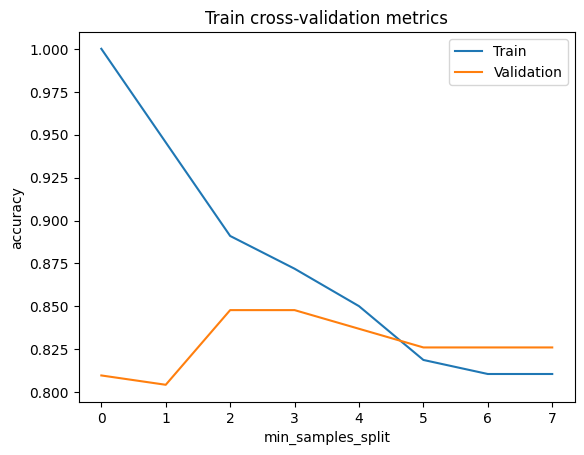

In [11]:
# Considering only min_samples_split_list
accuracy_list_train = []
accuracy_list_val = []
for min_samples_split in min_samples_split_list:
    model = DecisionTreeClassifier(min_samples_split = min_samples_split,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train)
    predictions_val = model.predict(X_val)
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.title('Train cross-validation metrics')
plt.legend(['Train','Validation'])

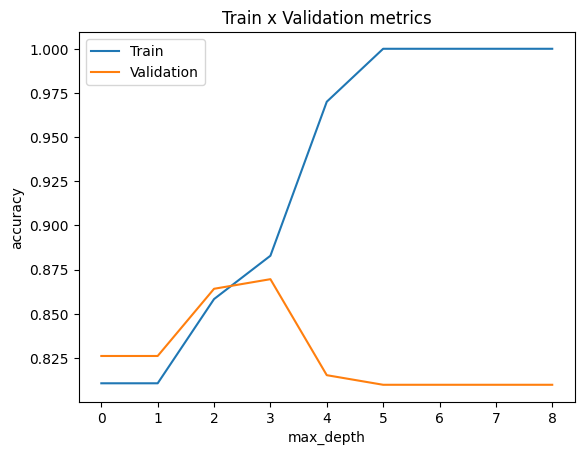

In [12]:
# Considering only max_depth
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeClassifier(max_depth = max_depth,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

In [13]:
'''From  the above models we can make the following observations:
    1) Increasing the the number of min_samples_split reduces overfitting.
    2) Increasing min_samples_split from 10 to 30, and from 30 to 50, 
       even though it does not improve the validation accuracy, 
       it brings the training accuracy closer to it, showing a reduction in overfitting.
    3) Decreasing the the max_depth reduces overfitting.
    4) Reducing max_depth from 8 to 4 increases validation accuracy closer to training accuracy, 
       while significantly reducing training accuracy.
    5) The validation accuracy reaches the highest at tree_depth=4.
    
    So in our decision tree model will we consider taking min_samples_split = 50 & max_depth = 4
''' 

'From  the above models we can make the following observations:\n    1) Increasing the the number of min_samples_split reduces overfitting.\n    2) Increasing min_samples_split from 10 to 30, and from 30 to 50, \n       even though it does not improve the validation accuracy, \n       it brings the training accuracy closer to it, showing a reduction in overfitting.\n    3) Decreasing the the max_depth reduces overfitting.\n    4) Reducing max_depth from 8 to 4 increases validation accuracy closer to training accuracy, \n       while significantly reducing training accuracy.\n    5) The validation accuracy reaches the highest at tree_depth=4.\n    \n    So in our decision tree model will we consider taking min_samples_split = 50 & max_depth = 4\n'

In [14]:
decision_tree_model = DecisionTreeClassifier(min_samples_split = 50,
                                             max_depth = 3,
                                             random_state = RANDOM_STATE).fit(X_train,y_train)
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_train),y_train):.4f}")
print(f"Metrics validation:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.8583
Metrics validation:
	Accuracy score: 0.8641


In [15]:
# We have successfull reduced overfitting while also achieving 86% accuracy in validation set